## Import

In [2]:
import pickle
import matplotlib.pyplot as plt
import warnings

# from config import CONFIG
# from easydict import EasyDict

import numpy as np
import random
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from models.DLinear import *

import time

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load

In [4]:
with open('../data/processed/kospi200_ffill_clean_version.pkl', 'rb') as f:
    df = pickle.load(f)

df.head(5)

,date,time,open,high,low,close,prevClose,vol
2010-02-16 09:01:00,20100216,901,207.55,207.65,207.50,207.60,207.5,3985.0
2010-02-16 09:02:00,20100216,902,207.60,207.65,207.25,207.55,207.5,5095.0
2010-02-16 09:03:00,20100216,903,207.55,207.80,207.50,207.60,207.5,2175.0
2010-02-16 09:04:00,20100216,904,207.55,207.85,207.55,207.80,207.5,1301.0
2010-02-16 09:05:00,20100216,905,207.80,208.15,207.80,208.05,207.5,3870.0


## Test DLinear

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len=80, pred_len=1):
        self.data = df.values.astype(np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len

        self.mean = np.mean(self.data, axis=0)
        self.sd = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean) / self.sd
    
    def __getitem__(self, idx):
        x = self.norm_data[idx : idx + self.seq_len].transpose()
        y = self.norm_data[idx + self.seq_len : idx + self.seq_len + self.pred_len].transpose()
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len

    def inverse_transform(self, data, idx):
        data = np.array(data)
        return data * self.sd[idx] + self.mean[idx]

In [8]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [11]:
data = df[['close', 'vol']]
LEARN_RATE = 0.0005

WINDOW_SIZE = 21
SEQ_LEN = 80
PRED_LEN = 20
CHANNEL_SIZE = 2
BATCH_SIZE = 64

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

total_len = len(data)
train_end_idx = int(total_len * 0.7)
test_start_idx = int(total_len * 0.85)

train_dataset = TimeSeriesDataset(df=data.iloc[:train_end_idx], seq_len=SEQ_LEN, pred_len=PRED_LEN)
valid_dataset = TimeSeriesDataset(df=data.iloc[train_end_idx:test_start_idx], seq_len=SEQ_LEN, pred_len=PRED_LEN)
test_dataset = TimeSeriesDataset(df=data.iloc[test_start_idx:], seq_len=SEQ_LEN, pred_len=PRED_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = DLinearModel(window_size=WINDOW_SIZE, seq_len=SEQ_LEN, pred_len=PRED_LEN, channel_size=CHANNEL_SIZE, device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARN_RATE)
loss_ftn = nn.MSELoss().to(device)
decomposer = Decomposition(window_size=WINDOW_SIZE, channel_size=1, device=device)

Using device: mps


Info--[[seq_len: 80, pred_len: 20, window_size: 21]]
epoch [5/200] | loss: 14.766 -- time: 58.165
epoch [10/200] | loss: 8.224 -- time: 61.066
epoch [15/200] | loss: 8.209 -- time: 61.367
epoch [20/200] | loss: 8.225 -- time: 61.743
epoch [25/200] | loss: 8.222 -- time: 75.342
start valid
valid loss: 2.052


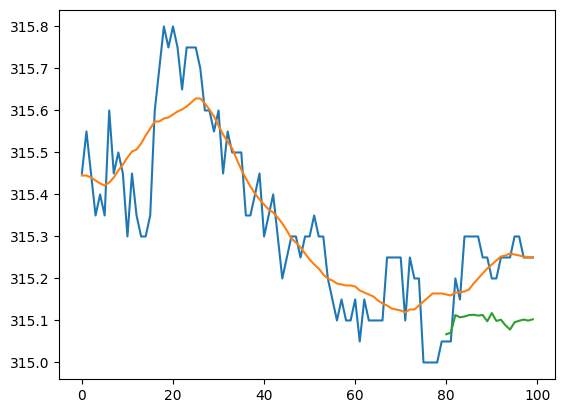

epoch [30/200] | loss: 8.23 -- time: 78.008
epoch [35/200] | loss: 8.209 -- time: 75.302
epoch [40/200] | loss: 8.215 -- time: 71.918
epoch [45/200] | loss: 8.222 -- time: 74.626
epoch [50/200] | loss: 8.219 -- time: 74.29
start valid
valid loss: 1.969


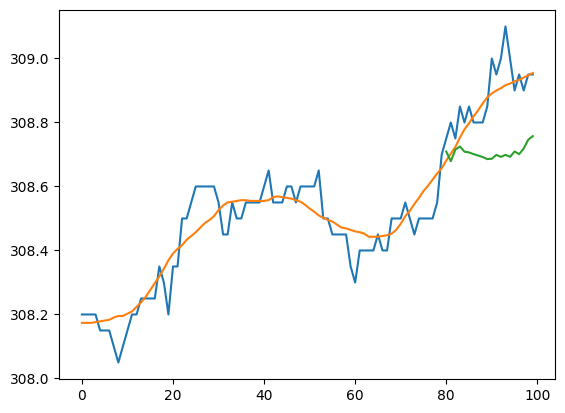

save model
epoch [55/200] | loss: 8.214 -- time: 78.629
epoch [60/200] | loss: 8.22 -- time: 81.035
epoch [65/200] | loss: 8.211 -- time: 72.244
epoch [70/200] | loss: 8.21 -- time: 72.093
epoch [75/200] | loss: 8.223 -- time: 72.188
start valid
valid loss: 2.021


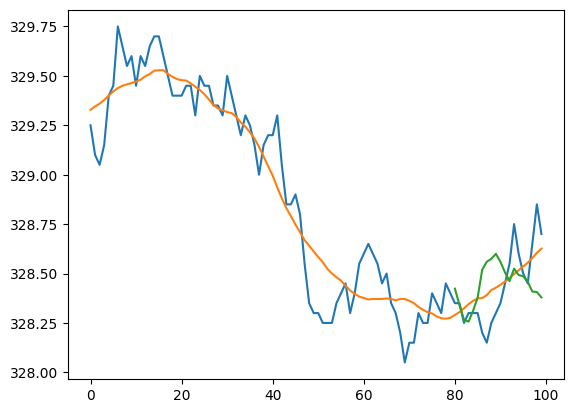

epoch [80/200] | loss: 8.212 -- time: 72.398
epoch [85/200] | loss: 8.213 -- time: 68.564
epoch [90/200] | loss: 8.216 -- time: 50.22
epoch [95/200] | loss: 8.211 -- time: 33.824
epoch [100/200] | loss: 8.22 -- time: 35.534
start valid
valid loss: 2.086


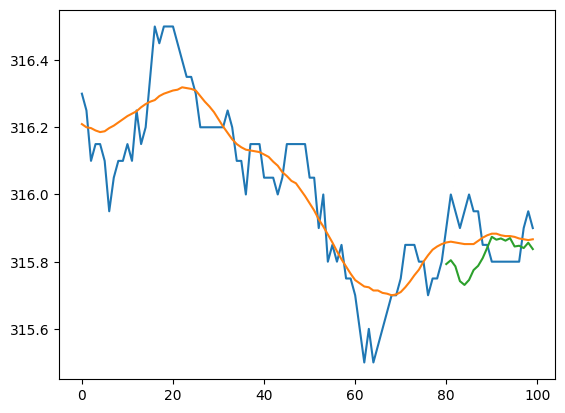

save model
epoch [105/200] | loss: 8.222 -- time: 73.917
epoch [110/200] | loss: 8.221 -- time: 76.097
epoch [115/200] | loss: 8.215 -- time: 71.789
epoch [120/200] | loss: 8.221 -- time: 77.354
epoch [125/200] | loss: 8.225 -- time: 74.81
start valid
valid loss: 2.093


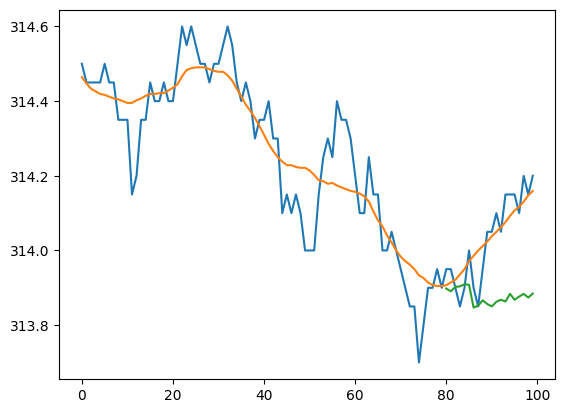

epoch [130/200] | loss: 8.221 -- time: 74.216
epoch [135/200] | loss: 8.223 -- time: 73.029
epoch [140/200] | loss: 8.213 -- time: 75.009
epoch [145/200] | loss: 8.216 -- time: 68.992
epoch [150/200] | loss: 8.208 -- time: 60.156
start valid
valid loss: 1.948


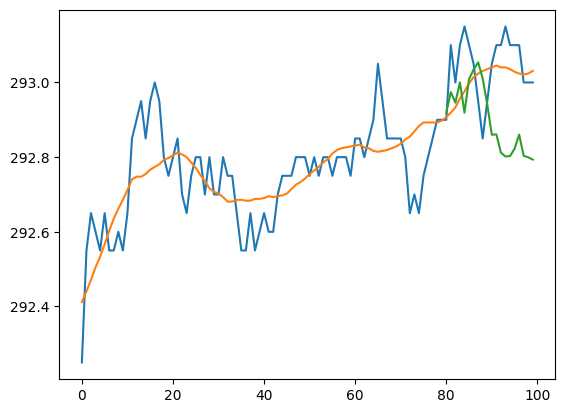

save model
epoch [155/200] | loss: 8.212 -- time: 76.067
epoch [160/200] | loss: 8.227 -- time: 81.496
epoch [165/200] | loss: 8.218 -- time: 64.339
epoch [170/200] | loss: 8.218 -- time: 61.684
epoch [175/200] | loss: 8.215 -- time: 61.346
start valid
valid loss: 2.157


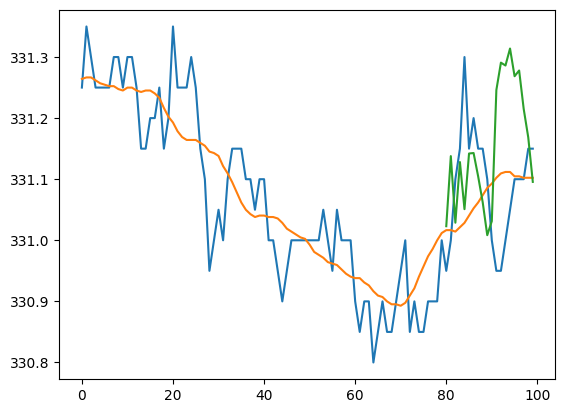

epoch [180/200] | loss: 8.211 -- time: 63.888
epoch [185/200] | loss: 8.219 -- time: 69.501
epoch [190/200] | loss: 8.224 -- time: 70.595
epoch [195/200] | loss: 8.234 -- time: 74.464
epoch [200/200] | loss: 8.213 -- time: 74.416
start valid
valid loss: 3.174


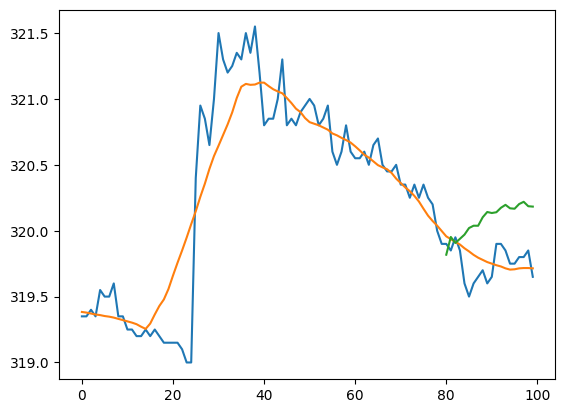

save model


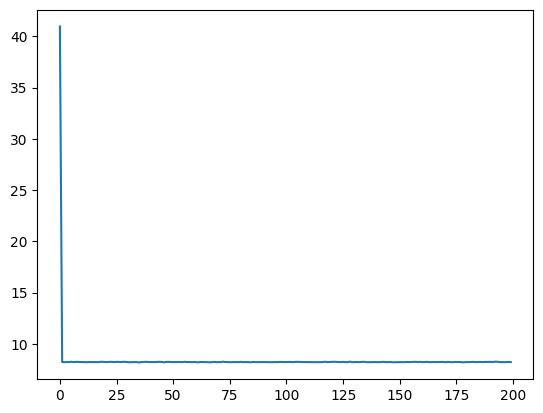

start test
test loss: 4.238


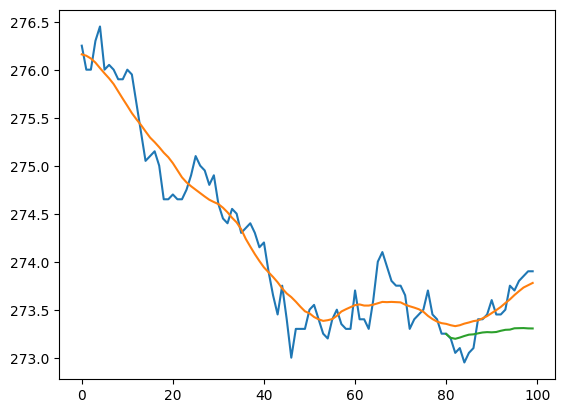

In [12]:
# train
train_data_len = len(train_dataset)
valid_data_len = len(valid_dataset)
test_data_len = len(test_dataset)
loss_list = []
valid_loss_list = []

time_list = []

PRINT_FREQ = 5
VALID_FREQ = 25
SAVE_FREQ = 50
EPOCH = 200

print(f"Info--[[seq_len: {SEQ_LEN}, pred_len: {PRED_LEN}, window_size: {WINDOW_SIZE}]]")

for epoch in range(EPOCH):
    current_time = time.time()
    model.train()
    epoch_loss = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        pred_y = model.forward(x)
        loss = loss_ftn(pred_y[:,0], y[:,0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.to('cpu').item()
    
    loss_list.append(epoch_loss)
    time_list.append(time.time() - current_time)

    if (epoch+1) % PRINT_FREQ == 0:
        print(f"epoch [{epoch+1}/{EPOCH}] | loss: {np.round(np.mean(loss_list[-PRINT_FREQ:]), 3)} -- time: {np.round(np.mean(time_list[-PRINT_FREQ:]), 3)}")

    if (epoch+1) % VALID_FREQ == 0:
        print("start valid")
        model.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            pred_y = model.forward(x)
            loss = loss_ftn(pred_y[:,0], y[:,0])
            valid_loss += loss.to('cpu').item()

        valid_loss_list.append(valid_loss)
        print(f"valid loss: {np.round(valid_loss, 3)}")
        
        # visualize
        idx = random.randint(0, len(valid_dataset) - 1)  # 무작위 인덱스 선택
        x, y = valid_dataset[idx]
        x_torch = torch.tensor(x, dtype=torch.float32).to(device)
        pred_y = model.forward(x_torch).to('cpu')
        plot_data = np.concat([x[0,:], y[0,:]])
        plot_data = valid_dataset.inverse_transform(plot_data, 0)
        torch_plot_data = torch.tensor(plot_data).unsqueeze(0).unsqueeze(0).to(device)
        trend, _ = decomposer.forward(torch_plot_data)
        pred_data = valid_dataset.inverse_transform(pred_y[0,:].tolist(), 0)
        plt.plot(plot_data)
        plt.plot(trend.cpu().squeeze().squeeze().tolist())
        plt.plot(range(SEQ_LEN, SEQ_LEN + PRED_LEN), pred_data)
        plt.show()

        if (epoch+1) % SAVE_FREQ == 0:
            print("save model")
            with open(f'model_s{SEQ_LEN}p{PRED_LEN}w{WINDOW_SIZE}.pkl', 'wb') as f:
                pickle.dump(model, f)

with open(f'dlinear_models/model_s{SEQ_LEN}p{PRED_LEN}w{WINDOW_SIZE}.pkl', 'wb') as f:
    pickle.dump(model, f)

# visualize loss
plt.plot(loss_list)
plt.show()

# test
print("start test")
model.eval()
test_loss = 0
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    pred_y = model.forward(x)
    loss = loss_ftn(pred_y[:,0], y[:,0])
    test_loss += loss.to('cpu').item()

print(f"test loss: {np.round(test_loss, 3)}")

# visualization
idx = random.randint(0, len(test_dataset) - 1)  # 무작위 인덱스 선택
x, y = test_dataset[idx]
x_torch = torch.tensor(x, dtype=torch.float32).to(device)
pred_y = model.forward(x_torch).to('cpu')
plot_data = np.concat([x[0,:], y[0,:]])
plot_data = test_dataset.inverse_transform(plot_data, 0)
torch_plot_data = torch.tensor(plot_data).unsqueeze(0).unsqueeze(0).to(device)
trend, _ = decomposer.forward(torch_plot_data)
pred_data = test_dataset.inverse_transform(pred_y[0,:].tolist(), 0)
plt.plot(plot_data)
plt.plot(trend.cpu().squeeze().squeeze().tolist())
plt.plot(range(SEQ_LEN, SEQ_LEN + PRED_LEN), pred_data)
plt.show()

In [27]:

    # if (epoch+1) % VALID_FREQ == 0:
    #     print("start valid")
    #     model.eval()
    #     valid_loss = 0
    #     pred_array = np.full(shape=(len(valid_loader.dataset)+1, PRED_LEN + len(valid_loader.dataset) - 1), fill_value=np.nan)
    #     cum_idx = 0
    #     for x, y in valid_loader:
    #         x = x.unsqueeze(1)
    #         pred_y = model.forward(x).squeeze(1)
    #         # pred_y = model.forward(x)
    #         loss = loss_ftn(pred_y, y)
    #         valid_loss += loss.item()

    #         pred_y = pred_y.squeeze()
    #         for i in range(len(x)):
    #             pred_array[cum_idx + i, cum_idx + i : cum_idx + i + PRED_LEN] = pred_y[i].tolist()

    #         cum_idx += len(x)

    #     valid_loss_list.append(valid_loss)
    #     print(f"valid loss: {np.round(valid_loss_list[-1], 3)}")
    #     pred_list = np.nanmean(pred_array, axis=0)
    #     pred_list = valid_dataset.inverse_transform(pred_list)
    #     plt.plot(valid_loader.dataset.data)
    #     plt.plot(range(SEQ_LEN+1, SEQ_LEN + len(valid_loader.dataset) + PRED_LEN), pred_list)
    #     plt.show()